In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 180 (delta 78), reused 134 (delta 49), pack-reused 0
Receiving objects: 100% (180/180), 28.64 MiB | 26.93 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=15097 sha256=3208bd91bdf32ed7dd114e3ab27fedf7b969839aceefcbc4c7aefccc595084c9
  Stored in directory: /tmp/pip-ephem-wheel-cache-b3jee4c5/wheels/55/59/29/0fb1c63565215773

In [ ]:
from dul_2021.utils.hw3_utils import *

In [ ]:
import os
import numpy as np
import copy
from itertools import chain

import torch
import torch.nn as nn
import torch.optim as opt
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Question 1: Autoregressive Flows for Images

Adapt your PixelCNN implementation from Homework 2 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 2 1(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


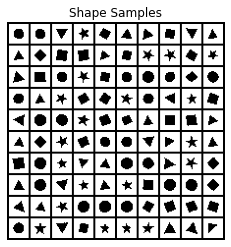

In [ ]:
visualize_q1_data()

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
import torch.nn as nn

class OptionalMaskLayer(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(OptionalMaskLayer, self).__init__(*args, **kwargs)
        self.mask = self.weight.data.clone().to(device)
        _, depth, height, width = self.weight.size()

        self.mask.fill_(1)
        self.mask_type = mask_type
        self.height = height
        self.width = width

        self.ddepth = depth // 3

        if mask_type == 'A':
            self.mask[:, :, height // 2, width // 2:] = 0
            self.mask[:, :, height // 2 + 1:, :] = 0
        else:
            self.mask[:, :, height // 2, width // 2 + 1:] = 0
            self.mask[:, :, height // 2 + 1:, :] = 0

        nn.init.kaiming_uniform_(self.weight.data,nonlinearity='relu')
        if self.bias is not None:
              nn.init.constant_(self.bias.data, 0)

    def forward(self, x):
        self.weight.data *= self.mask
        return super(OptionalMaskLayer, self).forward(x)


class OptionalResnetBlock(nn.Module):
  def __init__(self, in_channels, **kwargs):
    super().__init__()

    self.relu = nn.ReLU()
    self.conv1 = OptionalMaskLayer('B', in_channels, in_channels // 2, 1, **kwargs)
    self.conv2 = OptionalMaskLayer('B', in_channels // 2, in_channels // 2, 7, padding=3, **kwargs)
    self.conv3 = OptionalMaskLayer('B', in_channels // 2, in_channels, 1, **kwargs)

  def forward(self, x):
    x_skip = x
    x = self.relu(x)
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.conv3(x)
    
    return x + x_skip


class NormLayer(nn.LayerNorm):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, x):
    x = x.permute(0, 2, 3, 1).contiguous()
    x = super().forward(x)
    return x.permute(0, 3, 1, 2).contiguous()


class PixelCNNBlock(nn.Module):
  def __init__(self, kernel=7, channels=64, device=None):
    super(PixelCNNBlock, self).__init__()

    self.channels = channels
    self.kernel = kernel
    
    self.norm = NormLayer(self.channels)
    self.relu = nn.ReLU(True)
    self.resnet_block = OptionalResnetBlock(self.channels, bias=False)
    
  def forward(self, x):
    x = self.norm(x)
    x = self.relu(x)
    x = self.resnet_block(x)
    return x

class PixelCNNBackbone(nn.Module):
  def __init__(self, input_shape, n_layers=8, kernel=7, channels=120, device=None):
    super(PixelCNNBackbone, self).__init__()

    self.channels = channels
    self.kernel = kernel
    self.n_layers = n_layers
    self.h, self.w, self.c = input_shape
    
    self.model = self._make_layers()

    self.out = nn.Conv2d(self.channels, 2, 1)
    nn.init.kaiming_uniform_(self.out.weight.data,nonlinearity='relu')
    if self.out.bias is not None:
      nn.init.constant_(self.out.bias.data, 0)

  def _make_layers(self):
    layers = [OptionalMaskLayer('A', self.c, self.channels, self.kernel, 1, self.kernel//2, bias=False)]

    for i in range(self.n_layers):
      layers.append(PixelCNNBlock(channels=self.channels))

    return nn.Sequential(*layers)
    
  def forward(self, x):
    for layer in self.model:
       x = layer.forward(x)
    return self.out(x)

class PixelCNN(nn.Module):
  def __init__(self, input_shape, n_layers=8, kernel=7, channels=120, device=None, comp=2):
    super(PixelCNN, self).__init__()
    self.nin = np.prod(input_shape)
    self.device = device
    self.n = 2
    self.nll_loss = nn.NLLLoss()
    self.channels = channels
    self.kernel = kernel
    self.h, self.w, self.c = input_shape
    self.comp = comp
    # self.h, self.w = input_shape
    
    self.r_backbone = PixelCNNBackbone(input_shape, n_layers, kernel, channels, device)
    self.b_backbone = PixelCNNBackbone(input_shape, n_layers, kernel, channels, device)
    self.g_backbone = PixelCNNBackbone(input_shape, n_layers, kernel, channels, device)
    
  def forward(self, x):
    loc = self.r_backbone(x)
    log_scale = self.g_backbone(x)
    weight_logits = self.b_backbone(x)
    
    return loc, log_scale, weight_logits
    
  def loss(self, x):
    loc, log_scale, weight_logits = self(x)
    weights = F.softmax(weight_logits, dim=1) #.repeat(1, 1, self.n_components, 1, 1)
    log_det_jacobian = Normal(loc, log_scale.exp()).log_prob(x.unsqueeze(1).repeat(1,1,self.comp,1,1))
    return -log_det_jacobian.mean()

  def predict(self, testloader):
    loss = 0
    tl = 0
    with torch.no_grad():
      for batch in testloader:
        batch = batch.to(device)
        loss += self.loss(batch.to(device).float()) * batch.shape[0]
        tl += batch.shape[0]
        return loss / tl
    
  def fit(self, train_data, test_data, epochs=10, lr=1e-3, batch_size=128):
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size, 
                                               shuffle=True)
    
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size)
    train_loss = []
    test_loss = []
    test_loss.append(self.predict(test_loader))
    optim = opt.Adam(self.parameters(), lr=lr)
    
    for epoch in tqdm(range(epochs)):
      for batch in train_loader:
        batch = batch.to(device)
        batch = batch.float()
        loss = self.loss(batch)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss.append(self.predict(train_loader))
      test_loss.append(self.predict(test_loader))
    
    return train_loss, test_loss

  def sample(self, n=100):
    samples = torch.zeros(n, 1, 20, 20).cuda()
    with torch.no_grad():
      for r in range(20):
        for c in range(20):
            loc, log_scale, weight_logits = self(samples)
            try:
              loc, log_scale, weight_logits = loc[:,:,r,c], log_scale[:,:,r,c], weight_logits[:,:,r,c]
              probs = F.softmax(weight_logits, dim=1)
              chosen_centers = torch.multinomial(probs, 1).squeeze(-1)
              samples[:, 0, r, c] = torch.normal(loc[torch.arange(n), chosen_centers], log_scale[torch.arange(n), chosen_centers].exp())
            except Exception as e:
              print(loc.size())
              print(weight_logits.size())
              print(probs.size())
              print(chosen_centers.size())
              raise e
    return samples.permute(0, 2, 3, 1).cpu().numpy()

In [ ]:
def q1(train_data, test_data):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  H = W = 20
  Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
  """
  train_data = train_data.transpose(0, 3, 1, 2)
  test_data = test_data.transpose(0, 3, 1, 2)
  test_data = test_data + np.random.uniform(high=0.5, size=test_data.shape)

  image_shape = (20, 20, 1)
  model = PixelCNN(image_shape).to(device)

  tr_loss, test_loss = model.fit(train_data, test_data, epochs=20, lr=1e-3, batch_size=128)
  samples = model.sample(100)

  return tr_loss, test_loss, samples

### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



100%|██████████| 20/20 [39:08<00:00, 117.43s/it]


Final Test Loss: 0.6434


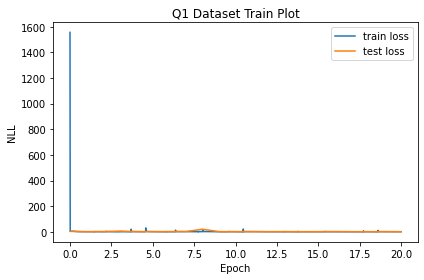

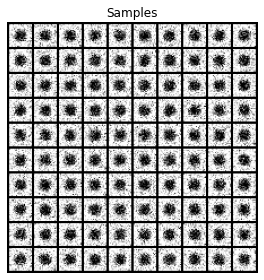

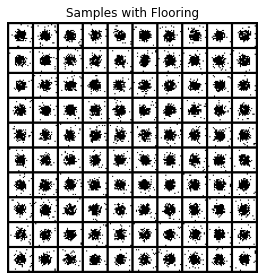

In [ ]:
q1_save_results(q1)